In [1]:
from datetime import datetime

In [85]:
import sunpy.map

In [111]:
calib_ratio = eis_ea(float(test_eis.meta['line_id'].split(' ')[-1]))/eis_ea_nrl(test_eis.date.value, float(test_eis.meta['line_id'].split(' ')[-1]))

[0.16098046]


In [117]:
calib_ratio

1.0130468135438595

In [39]:
def get_time_tai(date_string):
    # get the current time in TAI - specific for IDL.

    # IDL reference epoch: January 1, 1979, 00:00:00
    idl_ref_epoch = datetime(1979, 1, 1)

    # Unix epoch: January 1, 1970, 00:00:00
    unix_epoch = datetime(1970, 1, 1)

    # Calculate the difference in seconds between the IDL reference epoch and the Unix epoch
    epoch_diff = (idl_ref_epoch - unix_epoch).total_seconds()

    date_object = datetime.fromisoformat(date_string)
    unix_timestamp = date_object.timestamp()

    # Adjust the Unix timestamp by subtracting the epoch difference
    idl_timestamp = unix_timestamp - epoch_diff+3600

    return idl_timestamp

In [40]:
def read_calib_file():
    from scipy.io import readsav

    # Read the calibration file
    calib_file = readsav('eis_calibration/eis_calib_warren_2014.sav')
    return calib_file['eis']


In [41]:
eis = read_calib_file()

In [42]:
date = '2023-12-28T23:59:59'
t = (get_time_tai(date) - get_time_tai(eis['t0'][0].decode('utf-8')))/(86400.*365.25)
# tested, same in IDL

In [43]:
def eis_get_band(wave):
    # get band based on the wavelength
    band = ''
    sw_min = 165
    sw_max = 213
    pShort = (wave - sw_min) * (sw_max - wave)
    if pShort >= 0:
        band = 'SW'

    lw_min = 245
    lw_max = 292
    pLong = (wave - lw_min) * (lw_max - wave)
    if pLong >= 0:
        band = 'LW'

    return band

In [44]:
get_time_tai(date)

1419811199.0

In [55]:
t = (get_time_tai(date) - get_time_tai(eis['t0'][0].decode('utf-8')))/(86400*365.25)


In [56]:
ea_knots_SW = eis['a0_sw'][0]*np.exp(-t/eis['tau_sw'][0])
ea_knots_LW = eis['a0_lw'][0]*np.exp(-t/eis['tau_lw'][0])


In [58]:
eis['wave_area_sw'][0]

array([165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186.,
       187., 188., 189., 190., 191., 192., 193., 194., 195., 196., 197.,
       198., 199., 200., 201., 202., 203., 204., 205., 206., 207., 208.,
       209., 210., 211., 212., 213.], dtype='>f4')

In [73]:
import numpy as np
from scipy.interpolate import splrep, splev

def eis_ea_nrl(date, wave, short=False, long=False):
    eis = read_calib_file()
    t = (get_time_tai(date) - get_time_tai(eis['t0'][0].decode('utf-8')))/(86400*365.25)

    ea_knots_SW = eis['a0_sw'][0]*np.exp(-t/eis['tau_sw'][0])
    ea_knots_LW = eis['a0_lw'][0]*np.exp(-t/eis['tau_lw'][0])

    # -----------------------------------------------------------------
    # --- return the effective area on a default wavelength grid
    if short:
        wave = eis['wave_area_sw'][0]
    elif long:
        wave = eis['wave_area_lw'][0]

    # -----------------------------------------------------------------
    # --- spline onto the input wavelength grid
    if isinstance(wave, (int, float)):
        wave = np.array([wave])

    nWave = len(wave)
    ea_out = np.zeros(nWave)

    for i in range(nWave):
        band = eis_get_band(wave[i])

        if band == 'SW':
            w = eis['wave_knots_sw'][0]
            e = np.log(ea_knots_SW)
            s = 1
        elif band == 'LW':
            w = eis['wave_knots_lw'][0]
            e = np.log(ea_knots_LW)
            s = 1
        else:
            print(f"WAVELENGTH OUT OF BOUNDS {wave[i]}")
            s = 0

        if s == 1:
            tck = splrep(w, e)
            ea_out[i] = np.exp(splev(wave[i], tck))
            
        else:
            ea_out[i] = 0.0

    if nWave == 1:
        ea_out = ea_out[0]

    return ea_out


In [79]:
import numpy as np
from scipy.io import readsav
def eis_ea(input_wave, short=False, long=False):
    if short:
        wave, ea = eis_effective_area_read(short=True)
        input_wave = wave
        print(input_wave)
        return ea

    if long:
        wave, ea = eis_effective_area_read(long=True)
        input_wave = wave
        return ea
    if isinstance(input_wave, (int, float)):
        input_wave = np.array([input_wave])

    nWave = len(input_wave)
    ea = np.zeros(nWave)

    for i in range(nWave):
        short, long = is_eis_wavelength(input_wave[i])

        if not short and not long:
            ea[i] = 0.0
        else:
            wave, area = eis_effective_area_read(long=long, short=short)
            ea[i] = np.exp(np.interp(input_wave[i], wave, np.log(area)))

    if nWave == 1:
        ea = ea[0]

    return ea

def eis_effective_area_read(short=False, long=False):
    if short:
        preflight = readsav('eis_calibration/preflight_calib_short.sav')
    if long:
        preflight = readsav('eis_calibration/preflight_calib_long.sav')
    wave = preflight['wave']
    ea = preflight['ea']
    return wave, ea

def is_eis_wavelength(input_wave):
    wave_sw_min = 165
    wave_sw_max = 213
    wave_lw_min = 245
    wave_lw_max = 292

    long = False
    short = False

    ps = (input_wave - wave_sw_min) * (wave_sw_max - input_wave)
    if ps > 0:
        short = True

    pl = (input_wave - wave_lw_min) * (wave_lw_max - input_wave)
    if pl > 0:
        long = True

    out = long or short
    return short,long


In [83]:
eis_ea(195)

0.30180300929913173

In [84]:
date = '2007-12-28T23:59:59'

eis_ea_nrl(date,195)

[0.41812794]


0.4181279443915417

In [87]:
type(195.12) == float

True

In [95]:
input_wave = 195.12

In [96]:
input_wave = [input_wave]

In [97]:
input_wave

[195.12]

In [104]:
len(np.array([[195.12,193]]))

1

In [128]:
import matplotlib.pyplot as plt
import numpy as np

In [133]:
comp = np.load('/Users/andysh.to/Downloads/eis_20230327_092942_composition_sis.npz')

In [166]:
comp

NpzFile '/Users/andysh.to/Downloads/eis_20230327_092942_composition_sis.npz' with keys: composition, chi2, no_lines

In [167]:
comp['no_lines']

array([[ 9.,  9.,  9., ...,  6.,  6.,  5.],
       [12., 12., 12., ...,  7.,  6.,  8.],
       [12., 12., 12., ...,  7.,  7.,  8.],
       ...,
       [11., 16., 17., ..., 15., 13., 14.],
       [11., 16., 17., ..., 15., 16., 14.],
       [ 3.,  7.,  8., ...,  6.,  5.,  5.]])

Text(0.5, 1.0, 'EISPAC Default Calibration')

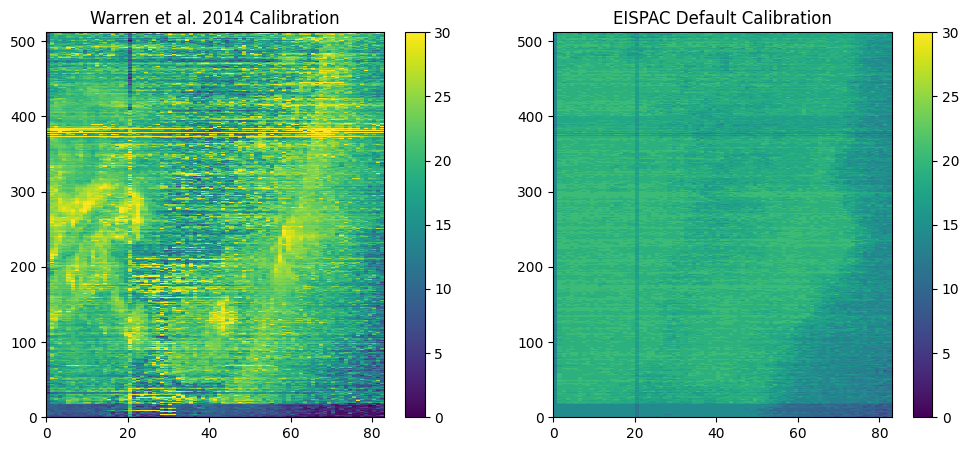

In [176]:
# fig = plt.figure(figsize=  (10,10))
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=  (12,5))
im1 = ax1.pcolormesh(comp['chi2'],vmin=0,vmax=30)
im2 = ax2.pcolormesh(comp_old['no_lines']*1.2,vmin=0,vmax=30)

# Add colorbars
cbar1 = fig.colorbar(im1, ax=ax1)
cbar2 = fig.colorbar(im2, ax=ax2)

ax1.set_title('Warren et al. 2014 Calibration')
ax2.set_title('EISPAC Default Calibration')

In [135]:
comp_old = np.load('/Users/andysh.to/Script/Python_Script/spice/images/composition/eis_20230327_092942_composition_sis.npz')

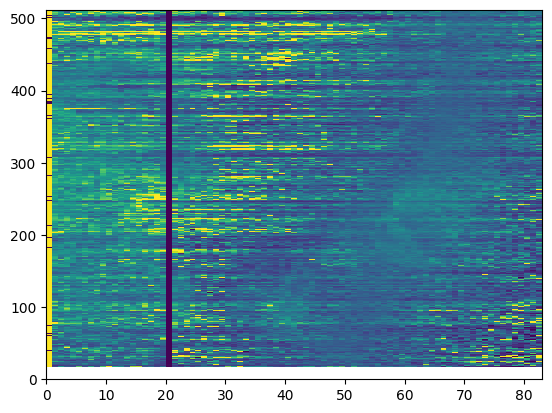

In [137]:
plt.pcolormesh(comp_old['composition'],vmin=0,vmax=4)